# Choose sectors, products and diversification paths
This notebook selects target products and sectors for diversification analysis. It focuses on identifying products based on strategic indicators like PCI, density, and proximity—both at the state and firm level.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [2]:
# Select which data and aggregation to use

data_choice = "labor" # trade / labor
labor_aggregation = "state" # state / metropolitan_area

In [3]:
# Importo tipografía Punto
import os
path = os.path.join(os.path.expanduser('~'), 'Documents/Proyectos/herramientas/')
import matplotlib.font_manager as font_manager
from matplotlib import rcParams
font_dir = [path + 'Raleway/']
for font in font_manager.findSystemFonts(font_dir):
    font_manager.fontManager.addfont(font)
rcParams['font.family'] = 'Raleway'
font_manager.fontManager

## 1. Read Data

In [4]:
pd.set_option('display.float_format', '{:.2f}'.format) 

In [5]:
# Directory structure and read database

if data_choice == "trade":
    DATASETS_DIR = './datasets_trade/'
    OUTPUTS_DIR = "./outputs_trade/"
    variable = "trade_value"
    code = "HS6"
    location = 'location'
    
elif data_choice == "labor":
    if labor_aggregation == "state":
        DATASETS_DIR = './datasets_labor_states/'
        OUTPUTS_DIR = "./outputs_labor_states/"
        variable = "EMP"
        location = "STATE_NAME"
        code = "NAICS2017"
    
    elif labor_aggregation == "metropolitan_area":
        DATASETS_DIR = './datasets_labor_metropolitan_area/'
        OUTPUTS_DIR = "./outputs_labor_metropolitan_area/"
        variable = "EMP"

In [6]:
relative_density = pd.read_parquet(OUTPUTS_DIR + "relative_density.parquet",engine='fastparquet')

pci = pd.read_parquet(OUTPUTS_DIR + "pci.parquet",engine='fastparquet')

relative_cog = pd.read_parquet(OUTPUTS_DIR + "relative_cog.parquet",engine='fastparquet')

products = pd.read_parquet(OUTPUTS_DIR + "codes.parquet",engine='fastparquet')

locations = pd.read_parquet(OUTPUTS_DIR + "locations.parquet",engine='fastparquet')

rca = pd.read_parquet(OUTPUTS_DIR + "RCA.parquet",engine='fastparquet')

mpa = pd.read_parquet(OUTPUTS_DIR + "Mpa.parquet",engine='fastparquet')

value_level = pd.read_parquet(OUTPUTS_DIR + "value_level.parquet",engine='fastparquet')

eci = pd.read_parquet(OUTPUTS_DIR + "eci.parquet",engine='fastparquet')

proximity = pd.read_parquet(OUTPUTS_DIR + "proximity.parquet",engine='fastparquet')

In [7]:
naics_equivalence = pd.read_excel(DATASETS_DIR + "NAICS_EQUIVALENCE.xlsx")
naics_equivalence.dtypes

naics_code              object
naics_description       object
level                    int64
parent_code             object
automotive_subsector    object
supply_chain_stage      object
sector_alignment        object
strategic_sector        object
dtype: object

In [8]:
sectors = pd.read_excel(DATASETS_DIR + "Sector classification NAICS 11.25.xlsx", sheet_name='NAICS')
sectors.rename(columns={"2022 NAICS Codes": "NAICS_6"}, inplace=True)
sectors['NAICS_6'] = sectors["NAICS_6"].apply(lambda x: f'{x:06}')
sectors = sectors.loc[sectors["Relevance"] == "Core"]
sectors_6digits = sectors[['NAICS_6', 'Strategic Sector']].drop_duplicates(subset=["NAICS_6", "Strategic Sector"], keep="first")
sectors_6digits.head()

,NAICS_6,Strategic Sector
0,336411,Aerospace
1,336412,Aerospace
2,336413,Aerospace
3,336414,Aerospace
4,336415,Aerospace


In [9]:
concordance_2017_2022 = pd.read_excel(DATASETS_DIR + "2017_to_2022_NAICS.xlsx")
concordance_2017_2022.rename(columns={"2017 NAICS Code": "code", "2022 NAICS Code" :"NAICS_2022", "2022 NAICS Title": "NAICS_Description"}, inplace=True)
concordance_2017_2022["code"] = concordance_2017_2022["code"].astype(str)
concordance_2017_2022["NAICS_2022"] = concordance_2017_2022["NAICS_2022"].astype(str)
concordance_2017_2022.head()

,code,2017 NAICS Title\n(and specific piece of the 2017 industry that is contained in the 2022 industry),NAICS_2022,NAICS_Description
0,111110,Soybean Farming,111110,Soybean Farming
1,111120,Oilseed (except Soybean) Farming,111120,Oilseed (except Soybean) Farming
2,111130,Dry Pea and Bean Farming,111130,Dry Pea and Bean Farming
3,111140,Wheat Farming,111140,Wheat Farming
4,111150,Corn Farming,111150,Corn Farming


In [10]:
codes = products.iloc[:, 0].astype(str) 

rel_cog_long = (relative_cog.stack().rename("relative_cog").to_frame())
rel_density_long = relative_density.stack().rename("density").to_frame()
rca_long         = rca.stack().rename("rca").to_frame()
mpa_long         = mpa.stack().rename("mcp").to_frame()
value_long       = value_level.stack().rename(variable).to_frame()

df_long = (rel_cog_long.join(rel_density_long).join(rca_long).join(mpa_long).join(value_long).reset_index())
df_long = df_long.rename(columns={df_long.columns[0]: "location", df_long.columns[1]: "code"})

df_pci = pd.DataFrame({"code": codes.values})
df_pci["pci"] = (pci.values)

df_full = df_long.merge(df_pci, on="code", how="left")

df_full = df_full.merge(concordance_2017_2022[["code", "NAICS_2022", "NAICS_Description"]], how="left", on="code")
df_full = df_full.merge(sectors_6digits[["NAICS_6", "Strategic Sector"]], left_on="NAICS_2022", right_on="NAICS_6", how="left")
df_full = df_full.drop(columns=["NAICS_6", "code"])
df_full = df_full.groupby(["location","NAICS_2022", "NAICS_Description", "Strategic Sector"], dropna=False).mean().reset_index()
df_full.head()

,location,NAICS_2022,NAICS_Description,Strategic Sector,relative_cog,density,rca,mcp,EMP,pci
0,Alabama,113110,Timber Tract Operations,NaN,-2.26,2.69,5.36,1.00,259.00,-0.50
1,Alabama,113210,Forest Nurseries and Gathering of Forest Products,NaN,-1.29,1.85,3.79,1.00,43.00,-0.50
2,Alabama,113310,Logging,NaN,-1.31,2.26,5.94,1.00,3483.00,-0.19
3,Alabama,114111,Finfish Fishing,NaN,-0.20,-0.71,0.24,0.00,10.00,1.32
4,Alabama,114112,Shellfish Fishing,NaN,-0.21,-0.86,0.77,0.00,16.00,1.25


In [11]:
pci_summary = df_full.loc[(df_full.mcp == 1)].groupby("location").agg(
    avg_pci=("pci", "mean"),
    median_pci=("pci", "median"),
    product_count=("NAICS_2022", "count"),
    high_complex_products=("pci", lambda x: (x > 1).sum()),
    low_complex_products=("pci", lambda x: (x < -1).sum())
).reset_index()

pci_summary.sort_values(by="avg_pci", ascending=False)

,location,avg_pci,median_pci,product_count,high_complex_products,low_complex_products
8,District of Columbia,1.07,1.11,129,72,0
11,Hawaii,0.72,0.70,174,59,0
4,California,0.70,0.67,345,117,4
32,New York,0.68,0.69,262,97,6
9,Florida,0.62,0.64,216,61,3
1,Alaska,0.54,0.52,210,50,1
20,Maryland,0.53,0.52,261,66,3
21,Massachusetts,0.47,0.56,271,78,13
5,Colorado,0.45,0.40,296,73,9
7,Delaware,0.44,0.52,193,45,8


In [12]:
df_full["naics_level2"] = df_full["NAICS_2022"].str[:2]
df_full = df_full.merge(naics_equivalence[["naics_code", "naics_description"]], left_on="naics_level2", right_on="naics_code", how="left")

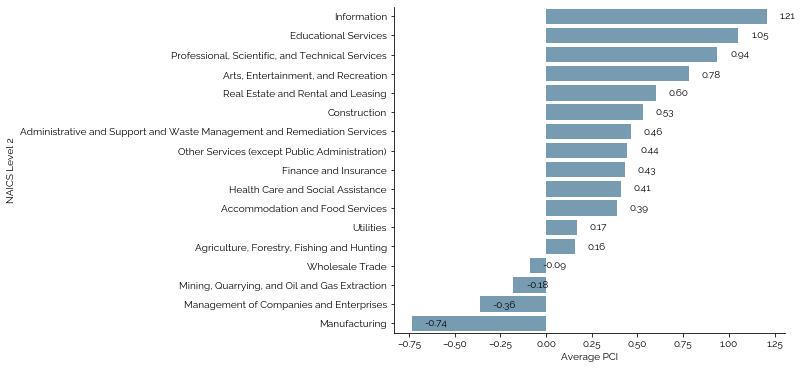

In [13]:
df_unique_products = df_full.drop_duplicates(subset=["NAICS_2022"])
pci_by_section = df_unique_products.groupby("naics_description")["pci"].mean().reset_index()
pci_by_section = pci_by_section.sort_values(by="pci", ascending=False).reset_index()

fig = plt.figure(figsize=(7, 6))
sns.barplot(data=pci_by_section, x="pci", y="naics_description", color="#6d9ebc")
plt.xlabel("Average PCI")
plt.ylabel("NAICS Level 2")
for index, row in pci_by_section.iterrows():
    plt.text(row["pci"] + 0.07, index, f"{row['pci']:.2f}", va='center')
sns.despine()
#fig.savefig("figs/pci_section.png", dpi=600, bbox_inches='tight', transparent=True)
plt.show()

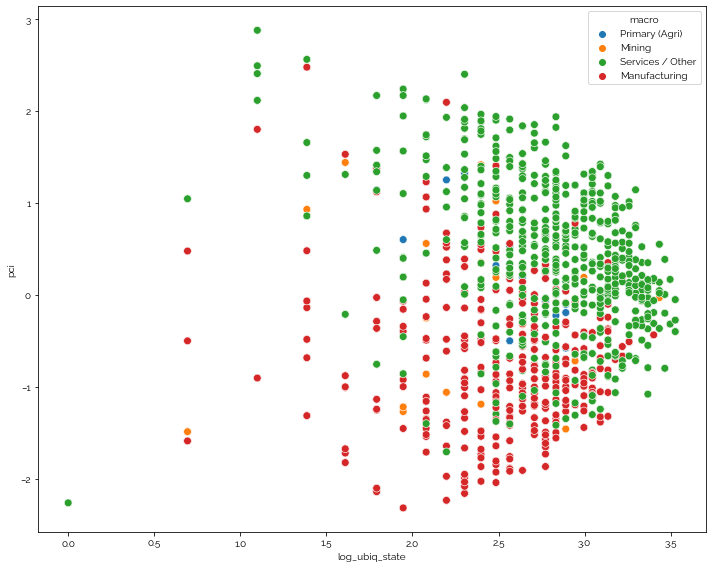

In [15]:
df_full["presence"] = (df_full["rca"] >= 1).astype(int)

ubiq = df_full.loc[df_full["presence"] == 1].groupby("NAICS_2022")["location"].nunique().rename("ubiq_state").reset_index()

pci_all = (df_full[["NAICS_2022", "pci"]].merge(ubiq, on="NAICS_2022", how="left"))
pci_all["log_ubiq_state"] = np.log(pci_all["ubiq_state"])

# Macro sector: identify manufacturing vs rest from NAICS2
def macro_sector(naics4):
    n2 = int(str(naics4)[:2])
    if 31 <= n2 <= 33:
        return "Manufacturing"
    elif n2 == 11:
        return "Primary (Agri)"
    elif n2 == 21:
        return "Mining"
    else:
        return "Services / Other"

pci_all["macro"] = pci_all["NAICS_2022"].apply(macro_sector)

plt.figure(figsize=(10,8))
sns.scatterplot(data=pci_all, x="log_ubiq_state", y="pci", hue="macro", s=60)
plt.tight_layout()
plt.show()

In [14]:
pci_by_section

,index,naics_description,pci
0,8,Information,1.19
1,5,Educational Services,1.10
2,13,"Professional, Scientific, and Technical Services",0.93
3,3,"Arts, Entertainment, and Recreation",0.77
4,14,Real Estate and Rental and Leasing,0.60
5,4,Construction,0.52
6,1,Administrative and Support and Waste Managemen...,0.46
7,6,Finance and Insurance,0.45
8,12,Other Services (except Public Administration),0.45
9,7,Health Care and Social Assistance,0.41


In [9]:
df_full.shape

(48048, 10)

In [35]:
df_sector = df_full.loc[df_full["Strategic Sector"].isin(['Defense', 'Aerospace'])]

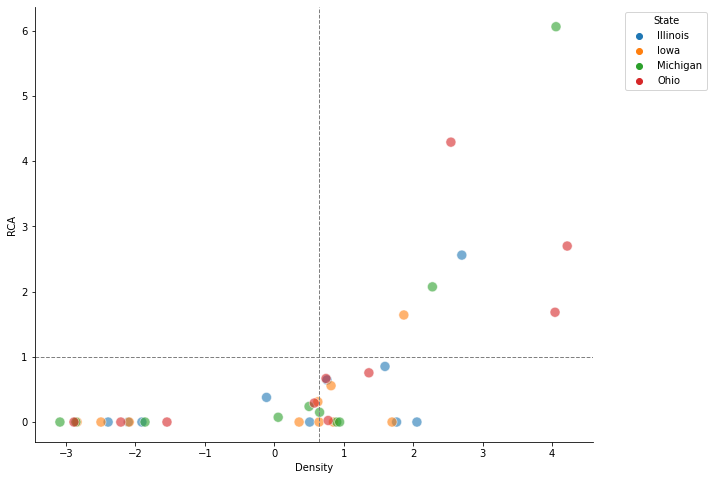

In [65]:
states_sel = ["Ohio", "Michigan", "Illinois", "Iowa"]
df_plot = df_sector[df_sector["location"].isin(states_sel)].copy()

plt.figure(figsize=(10,8))
sns.scatterplot(data=df_plot, x="density", y="rca",hue="location", alpha=0.6, s=100)
plt.axhline(1, ls="--", lw=1, color="grey")  # RCA = 1 threshold
plt.axvline(df_plot["density"].median(), ls="--", lw=1, color="grey")  # median density (only for selected states)
plt.xlabel("Density")
plt.ylabel("RCA")
plt.legend(title="State", bbox_to_anchor=(1.05, 1), loc="upper left")
sns.despine()
plt.show()

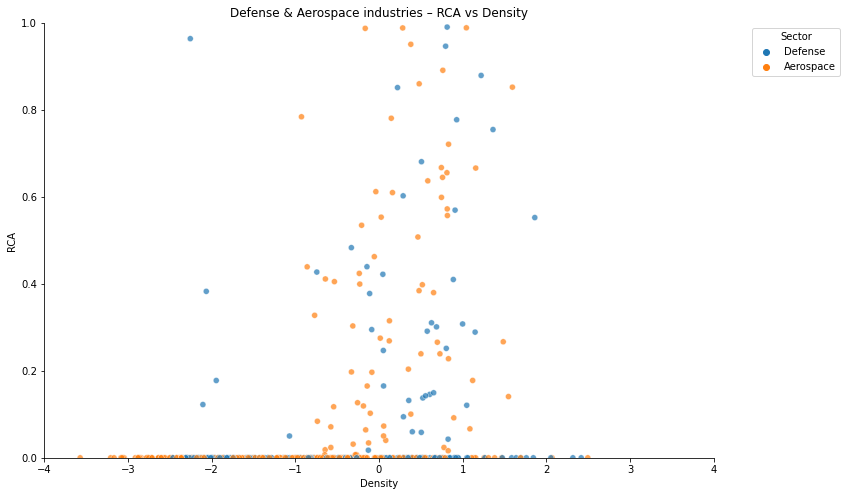

In [48]:
plt.figure(figsize=(12,8))
sns.scatterplot(data=df_sector, x="density", y="rca", hue="Strategic Sector", alpha=0.7)
plt.xlabel("Density")
plt.ylabel("RCA")
plt.title("Defense & Aerospace industries – RCA vs Density")
plt.legend(title="Sector", bbox_to_anchor=(1.05, 1), loc="upper left")
ylim = plt.ylim(0,1)
xlim = plt.xlim(-4,4)
sns.despine()
plt.show()

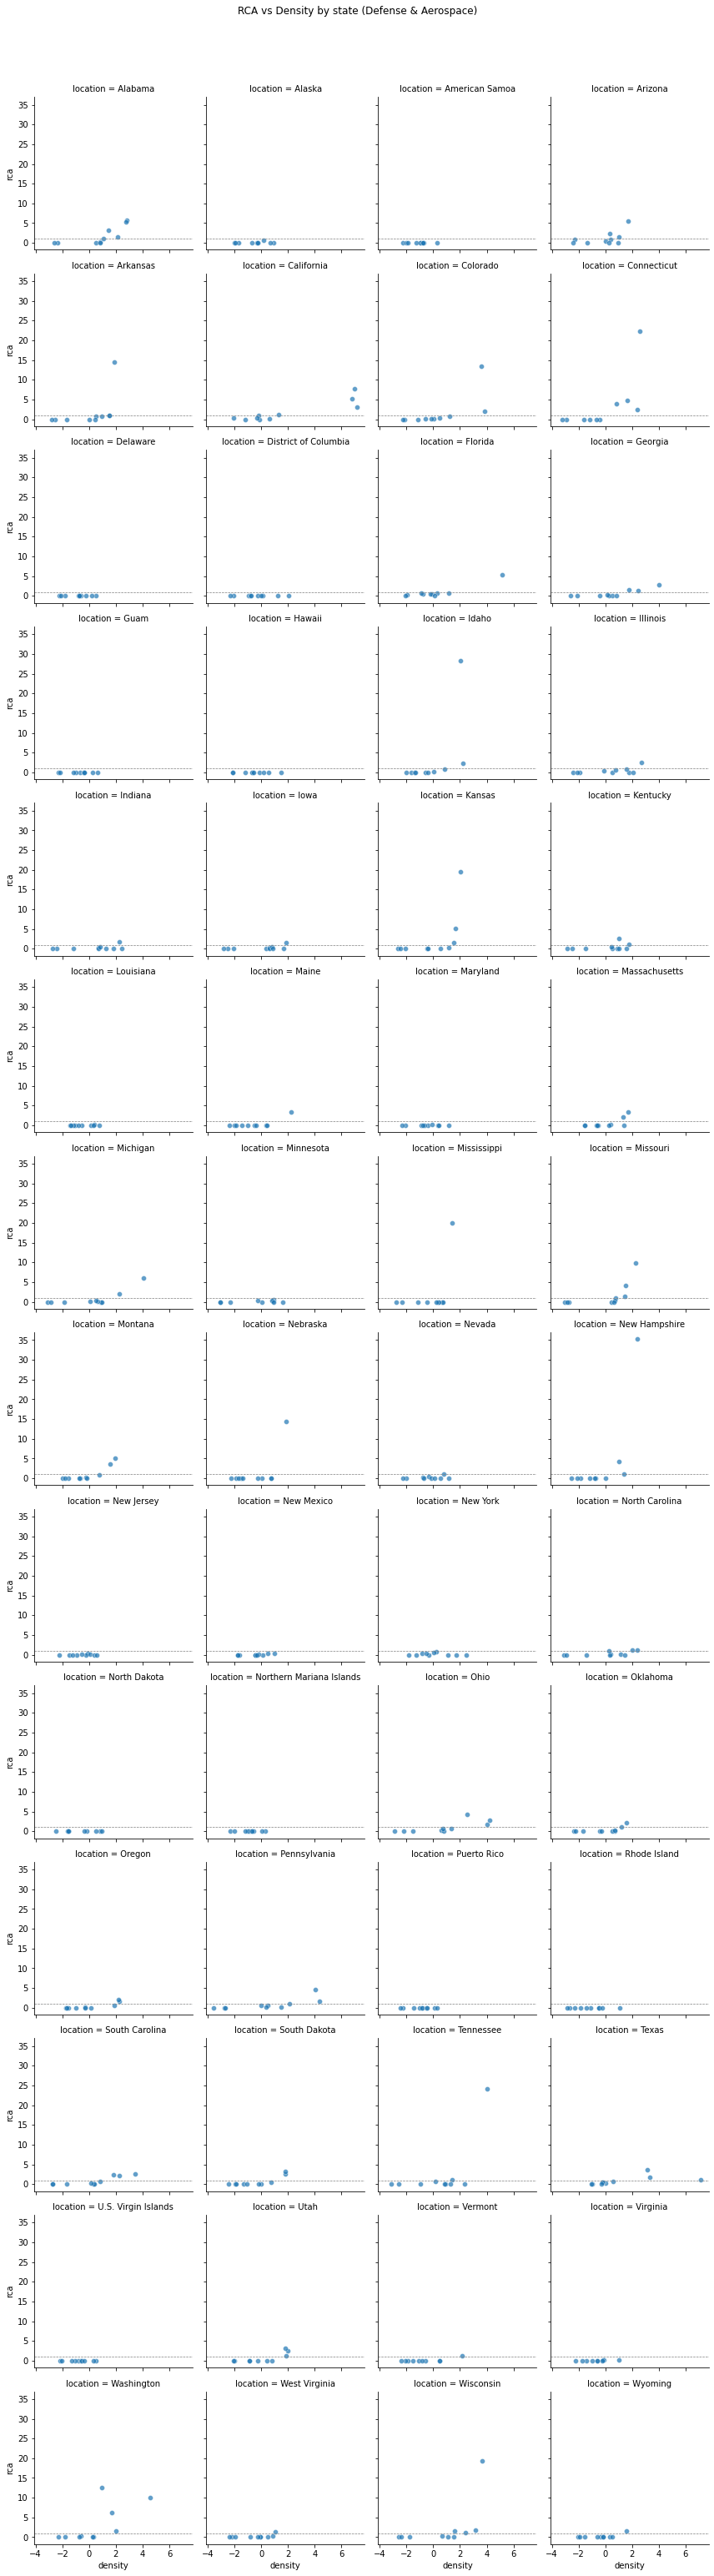

In [ ]:
g = sns.FacetGrid(df_sector, col="location", col_wrap=4, height=3, sharex=True, sharey=True)
g.map_dataframe(sns.scatterplot,x="density", y="rca",alpha=0.7)
for ax in g.axes.flatten():
    ax.axhline(1, ls="--", lw=0.7, color="grey")
    ax.set_xlabel("density")
    ax.set_ylabel("rca")
plt.tight_layout()
plt.show()

<ipython-input-42-1cec26c6296e>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_sector["rca_specialized"] = df_sector["rca"] >= 1


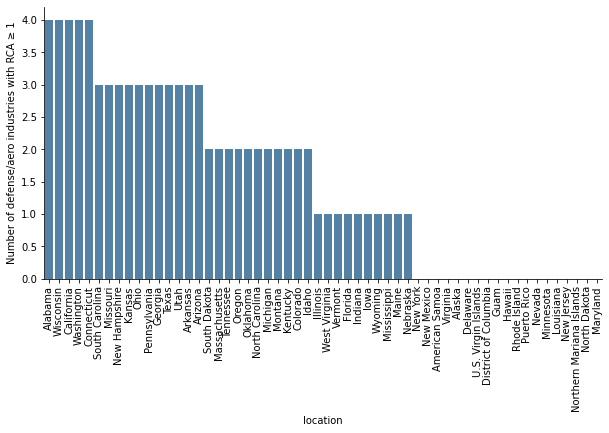

In [42]:
df_sector["rca_specialized"] = df_sector["rca"] >= 1
state_specialization = (df_sector.groupby("location", as_index=False).agg(n_specialized=("rca_specialized", "sum"),avg_density=("density", "mean"),
        avg_pci=("pci", "mean")))

plt.figure(figsize=(10,5))
state_specialization = state_specialization.sort_values("n_specialized", ascending=False)
sns.barplot(data=state_specialization,x="location", y="n_specialized", color ='steelblue')
plt.xticks(rotation=90)
plt.ylabel("Number of defense/aero industries with RCA ≥ 1")
sns.despine()
plt.show()

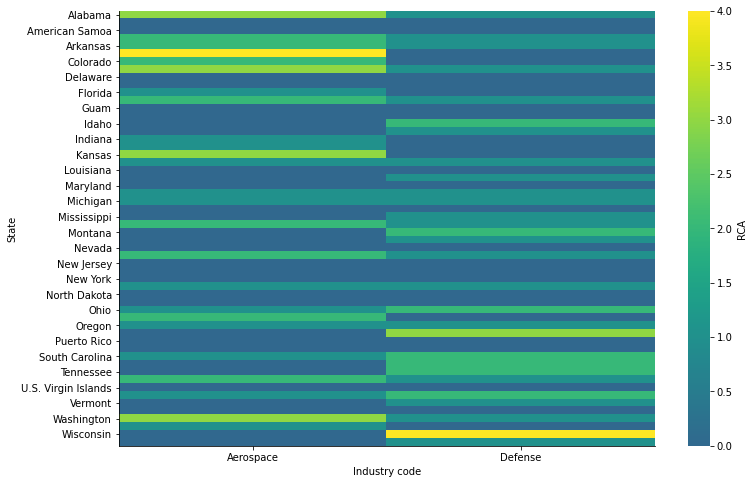

In [51]:
heat = df_sector.pivot_table( index="location",  columns="Strategic Sector", values="rca_specialized", aggfunc="sum")
plt.figure(figsize=(12,8))
sns.heatmap(heat, cmap="viridis",center=1,cbar_kws={"label": "RCA"})
plt.xlabel("Industry code")
plt.ylabel("State")
sns.despine()
plt.show()

In [53]:
import numpy as np

In [56]:
df_sector["specialized"] = df_sector["rca"] >= 1
df_sector["opportunity_density"] = np.where(df_sector["specialized"], np.nan, df_sector["density"])

state_readiness = (df_sector.groupby("location", as_index=False).agg(
        n_specialized      = ("specialized", "sum"),             # how many defense/aero NAICS with RCA≥1
        avg_rca_def        = ("rca", "mean"),                    # average RCA over all def/aero NAICS
        avg_density_all    = ("density", "mean"),                # overall ecosystem thickness
        opp_density_mean   = ("opportunity_density", "mean"))
)
state_readiness = state_readiness.sort_values("opp_density_mean", ascending=False)
state_readiness.head(5)

<ipython-input-56-9eacd6e9c77a>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_sector["specialized"] = df_sector["rca"] >= 1
<ipython-input-56-9eacd6e9c77a>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_sector["opportunity_density"] = np.where(df_sector["specialized"], np.nan, df_sector["density"])


,location,n_specialized,avg_rca_def,avg_density_all,opp_density_mean
16,Indiana,1,0.25,0.36,0.15
34,New York,0,0.22,0.07,0.07
15,Illinois,1,0.44,0.29,0.02
46,Tennessee,2,2.62,0.43,-0.15
17,Iowa,1,0.25,-0.06,-0.27


In [59]:
cols_to_show = ["location","n_specialized", "avg_rca_def","opp_density_mean"]
state_readiness.sort_values("opp_density_mean", ascending=False)[cols_to_show].head(10)

,location,n_specialized,avg_rca_def,opp_density_mean
16,Indiana,1,0.25,0.15
34,New York,0,0.22,0.07
15,Illinois,1,0.44,0.02
46,Tennessee,2,2.62,-0.15
17,Iowa,1,0.25,-0.27
19,Kentucky,2,0.42,-0.29
47,Texas,3,0.84,-0.29
0,Alabama,4,1.69,-0.30
25,Minnesota,0,0.13,-0.34
23,Massachusetts,2,0.58,-0.37


In [60]:
df_sector.loc[df_sector["location"] == "Ohio"].sort_values("opportunity_density", ascending=False)[["NAICS_2022", "NAICS_Description", "Strategic Sector", "rca", "density", "opportunity_density"]].head(10)

,NAICS_2022,NAICS_Description,Strategic Sector,rca,density,opportunity_density
35407,332992,Small Arms Ammunition Manufacturing,Defense,0.75,1.36,1.36
35500,336411,Aircraft Manufacturing,Aerospace,0.02,0.78,0.78
35502,336413,Other Aircraft Parts and Auxiliary Equipment M...,Aerospace,0.67,0.75,0.75
35409,332994,"Small Arms, Ordnance, and Ordnance Accessories...",Defense,0.29,0.58,0.58
35505,336419,Other Guided Missile and Space Vehicle Parts a...,Aerospace,0.00,-1.54,-1.54
35503,336414,Guided Missile and Space Vehicle Manufacturing,Aerospace,0.00,-2.21,-2.21
35504,336415,Guided Missile and Space Vehicle Propulsion Un...,Aerospace,0.00,-2.88,-2.88
35408,332993,Ammunition (except Small Arms) Manufacturing,Defense,1.68,4.04,NaN
35501,336412,Aircraft Engine and Engine Parts Manufacturing,Aerospace,4.29,2.54,NaN
35510,336992,"Military Armored Vehicle, Tank, and Tank Compo...",Defense,2.70,4.22,NaN
